In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm

! gdown --id 1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
from kernel_pde_utils import *
# test_step1()
# test_step2()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
To: /content/kernel_pde_utils.py
100% 4.81k/4.81k [00:00<00:00, 15.3MB/s]


# Pendulum Data Generation

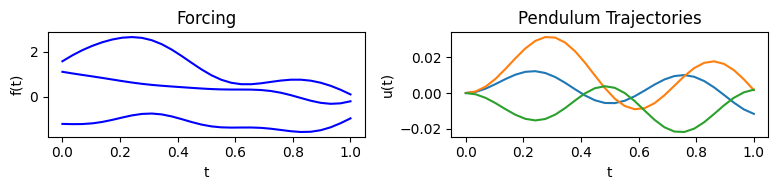

In [2]:
# Define pendulum parameter k=g/L.
k = 150

def build_pendulum_data(F, t):
    """
    F = (I, J) array of desired forcing terms
    t = (J,) array of times of data collection
    """
    # Define the pendulum governing equations.
    def pendulum(t, y, k, i):
        u1, u2 = y
        f = lambda t: F[i, int(t / dt)]
        return [u2, -(k * np.sin(u1)) + f(t)]

    # Define the pendulum traectories.
    U = np.empty(F.shape)
    for i in range(len(F)):
        sol = solve_ivp(
            pendulum,
            t_span=(t[0], t[-1]),
            y0=(0, 0),
            t_eval=t,
            args=(k, i),
        )
        U[i] = sol.y[0]

    return U

I = 3 # number of trajectories to consider
J = 30 # number of time points to consider

# Define time points between t=0 and t=1.
t = np.linspace(0, 1, J)
dt = t[1] - t[0]
T = t[:, None]

# Define the forcing terms f via a Gaussian Process.
rng = np.random.default_rng(seed=144) # seed for reproducibility 
rbf = RBF(length_scale=0.2)
mean = np.zeros(len(t))
cov = rbf(T)

# Build the forcing and the pendulum data.
F = rng.multivariate_normal(mean, cov, size=I)
U = build_pendulum_data(F, t)

# Plot forcing and pendulum trajectories.
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.title("Forcing")
for i in range(I):
    plt.plot(t, F[i], c="b")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.subplot(1, 2, 2)
plt.title("Pendulum Trajectories")
for i in range(I):
    plt.plot(t, U[i])
plt.xlabel("t")
plt.ylabel("u(t)")
plt.tight_layout()
plt.show()

# Apply to Pendulum Data!

In [3]:
def compute_error(true, est):
    """Relative error."""
    return np.linalg.norm(true - est) / np.linalg.norm(true)

def kernel_pipeline(u, f, t, params):
    # Get smooth u and its first derivative.
    T = t[:, None]
    u1_smooth = kernel_smoothing(
        T, u, kernel_metric="rbf",
        kernel_params={"gamma":params["gamma"]}, _lambda=params["lam_smooth"],
    )(T)
    u2_func = kernel_diff(
        T, u1_smooth, d=1, kernel_metric="rbf",
        kernel_params={"gamma":params["gamma"]}, _lambda=params["lam_smooth"],
    )
    u2 = np.array([u2_func(np.array(tj)) for tj in t])

    # Get smooth u2 and its first derivative.
    u2_smooth = kernel_smoothing(
        T, u2, kernel_metric="rbf",
        kernel_params={"gamma":params["gamma"]}, _lambda=params["lam_smooth"],
    )(T)
    u3_func = kernel_diff(
        T, u1_smooth, d=2, kernel_metric="rbf",
        kernel_params={"gamma":params["gamma"]}, _lambda=params["lam_smooth"],
    )
    u3 = np.array([u3_func(np.array(tj)) for tj in t])

    # Smooth out u3.
    u3_smooth = kernel_smoothing(
        T, u3, kernel_metric="rbf",
        kernel_params={"gamma":params["gamma"]}, _lambda=params["lam_smooth"],
    )(T)

    # Apply kernel regression.
    S = np.vstack([u1_smooth, u2_smooth]).T
    P1 = kernel_regression(
        S, u2_smooth,
        kernel_metric="poly", kernel_params={"gamma":1, "degree":params["deg"], "coef0":params["coef"]}, _lambda=params["lam_reg"],
    )
    P2 = kernel_regression(
        S, u3_smooth - f,
        kernel_metric="poly", kernel_params={"gamma":1, "degree":params["deg"], "coef0":params["coef"]}, _lambda=params["lam_reg"],
    )
    return P2(S)

def cross_validation(
    u, f, t, num_batch,
    all_gamma=[1, 10, 20, 50],
    all_lam_smooth=[1e-8, 1e-6, 1e-4],
    all_deg=[3, 4, 5],
    all_coef=[0.01, 0.1, 1],
    all_lam_reg=[1e-8, 1e-6, 1e-4],
):
    # Initialize the loss.
    current_loss = np.inf
    best_params = dict()

    # Define the training and validation batches.
    u_batches = np.split(u, num_batch)
    f_batches = np.split(f, num_batch)
    t_batches = np.split(t, num_batch)

    for (a, b, c, d, e) in tqdm(itertools.product(
        all_gamma, all_lam_smooth, all_deg, all_coef, all_lam_reg
    )):
        # Specify kernel pipeline parameters.
        params = {"gamma":a, "lam_smooth":b, "deg":c, "coef":d, "lam_reg":e}

        # Record the validation error.
        validation_error = np.empty(num_batch)

        for i, (u_val, f_val, t_val) in enumerate(zip(u_batches, f_batches, t_batches)):
            u_train = np.setdiff1d(u, u_val)
            f_train = np.setdiff1d(f, f_val)
            t_train = np.setdiff1d(t, t_val)
            P_true_train = -(k * np.sin(u_train))
            P_kernel = kernel_pipeline(u_train, f_train, t_train, params)
            validation_error[i] = compute_error(P_true_train, P_kernel)

        if np.average(validation_error) < current_loss:
            current_loss = np.average(validation_error)
            best_params = {"gamma":a, "lam_smooth":b, "deg":c, "coef":d, "lam_reg":e}

    return best_params

0it [00:00, ?it/s]WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
324it [21:30,  3.98s/it]


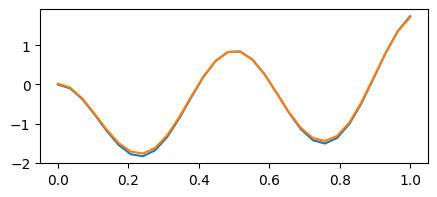

324it [21:22,  3.96s/it]


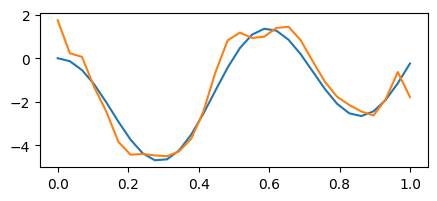

324it [21:27,  3.97s/it]


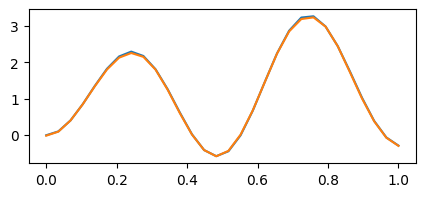

In [4]:
all_params = []
for i in range(I):
    best_params = cross_validation(U[i], F[i], t, num_batch=5)
    P_true = -(k * np.sin(U[i]))
    P_kernel = kernel_pipeline(U[i], F[i], t, best_params)
    plt.figure(figsize=(5, 2))
    plt.plot(t, P_true)
    plt.plot(t, P_kernel)
    plt.show()
    all_params.append(best_params)

In [5]:
print(all_params[0])
print(all_params[1])
print(all_params[2])

{'gamma': 10, 'lam_smooth': 0.0001, 'deg': 5, 'coef': 0.1, 'lam_reg': 0.0001}
{'gamma': 1, 'lam_smooth': 0.0001, 'deg': 5, 'coef': 0.1, 'lam_reg': 0.0001}
{'gamma': 10, 'lam_smooth': 0.0001, 'deg': 5, 'coef': 0.1, 'lam_reg': 0.0001}


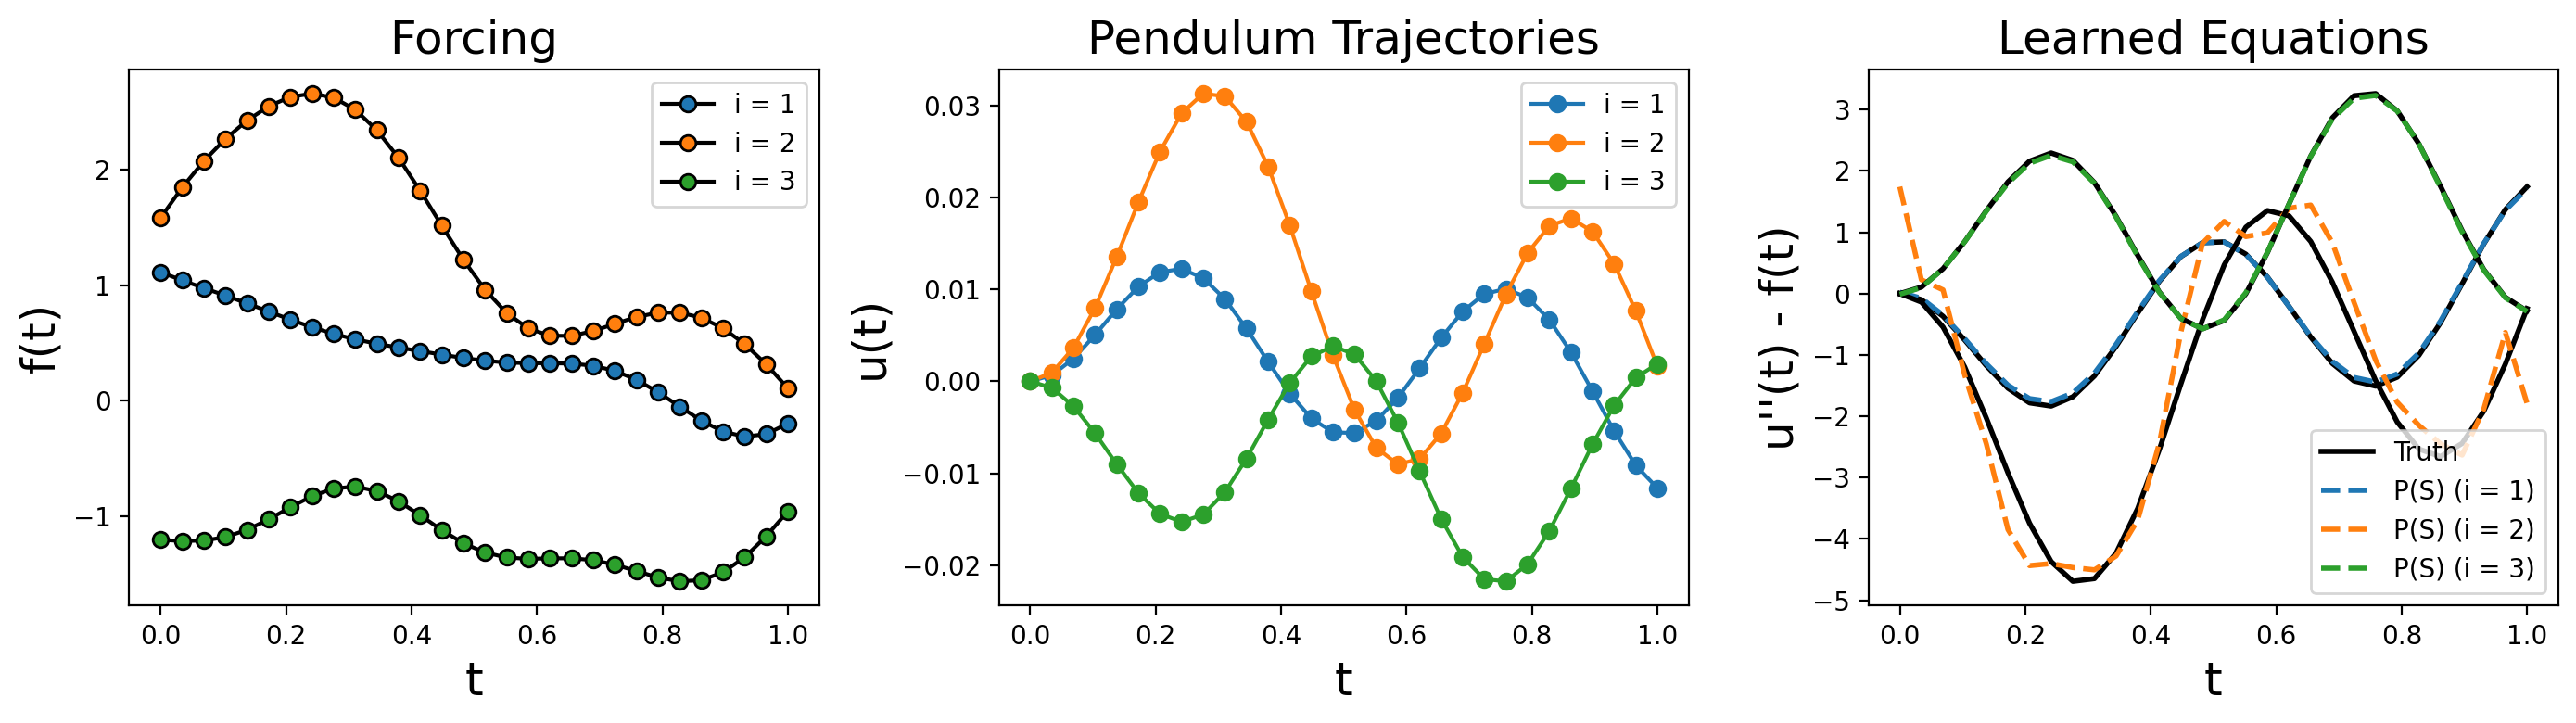

In [24]:
colors = ["tab:blue", "tab:orange", "tab:green"]

# Produce figure.
plt.figure(figsize=(14, 4), dpi=200)

plt.subplot(1, 3, 1)
plt.title("Forcing", fontsize=18)
for i in range(I):
    plt.plot(t, F[i], "-o", c="k", mec="k", mfc=colors[i], label=f"i = {i+1}")
plt.xlabel("t", fontsize=18)
plt.ylabel("f(t)", fontsize=18)
plt.legend(loc="upper right")

plt.subplot(1, 3, 2)
plt.title("Pendulum Trajectories", fontsize=18)
for i in range(I):
    plt.plot(t, U[i], "-o", c=colors[i], label=f"i = {i+1}")
plt.xlabel("t", fontsize=18)
plt.ylabel("u(t)", fontsize=18)
plt.legend(loc="upper right")

plt.subplot(1, 3, 3)
plt.title("Learned Equations", fontsize=18)
for i in range(I):
    P_true = -(k * np.sin(U[i]))
    P_kernel = kernel_pipeline(U[i], F[i], t, all_params[i])
    if  i == 0:
        plt.plot(t, P_true, c="k", label="Truth", lw=2)
    else:
        plt.plot(t, P_true, c="k", lw=2)
    plt.plot(t, P_kernel, "--", c=colors[i], label=f"P(S) (i = {i+1})", lw=2)
plt.xlabel("t", fontsize=18)
plt.ylabel("u''(t) - f(t)", fontsize=18)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()